# Applying Swedish data about waning of vaccine efficacy to current ECDC data

In [1]:
import pandas as pd

## Data processing functions

In [2]:
def get_normalized_week(row):
    # week is year-weekno (zero-padded), with 53 weeks per year, new year starting with week 1 not zero
    # so transferring 53 from 2020
    y, w = row.split('-')
    m = 0
    if y == '2021':
        m = 53
    
    w=w.replace('W','')
    if w[0] == '0':
        w = w[1]
    
    return int(w) + m


def get_bin(row):
    delay = df['Week'].max()-row
    # delay from current week (i.e. max week), in weeks
    if delay <= 2: # 14 days
        return 0
    if delay <= 4: # 15-28 days
        return 1
    if delay <= 8: #29-56 days
        return 2
    if delay <= 17: #57-119 days
        return 3
    if delay <= 25: #120-175 days
        return 4
    if delay <= 30: # 176-210 days
        return 5
    return 6

## Loading data

In [3]:
df =pd.read_excel('https://opendata.ecdc.europa.eu/covid19/vaccine_tracker/xlsx/data.xlsx')

### Looking at Poland only, change to your country if needed

In [4]:
df=df[df.ReportingCountry=='PL'].copy()

In [5]:
df['Week']=df['YearWeekISO'].apply(get_normalized_week)

In [6]:
df['Bin'] = df['Week'].apply(get_bin)

In [7]:
all_data = df[df['TargetGroup']=='ALL']

In [8]:
data_groups = all_data.groupby(['Region','Bin','Vaccine'])

In [9]:
second_dose = data_groups['SecondDose'].sum()

## Waning of waccination efficacy data per week group and vaccine type

Based on Table 2 from https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3949410

In [10]:
VACCINATION_EFF = {
    'MOD': {
        1: (.96, .94, .97),
        2: (.93, .9, .94),
        3: (.85, .82, .88),
        4: (.71, .56, .81),
        5: (.59, .18, .79),
        6: (.59, .18, .79),
    },
    'COM': {
        1: (.92, .92, .93),
        2: (.89, .88, .90),
        3: (.85, .84, .85),
        4: (.47, .39, .55),
        5: (.29, .15, .42),
        6: (.23, -.02, .41),
    },
    'AZ': {
        1: (.68, .52, .79),
        2: (.49, .28, .64),
        3: (.41, .29, .51),
        4: (-.19,-.97, .28),
        5: (-.19,-.97, .28),
        6: (-.19,-.97, .28),
    },    
}

### Let's generate random seeds for to get some variety in drawing samples

We're gonna use first 1k primes as seeds

In [11]:
#!wget -U IE8 https://primes.utm.edu/lists/small/1000.txt

In [12]:
from pathlib import Path
import re
spaces = re.compile('\s+')
a=Path('./1000.txt').read_text().split('\n')[4:-2]
seeds=[int(y) for x in a for y in spaces.sub(' ',x.strip()).split()]

In [13]:
from tqdm.notebook import tqdm
from pqdm.processes import pqdm
from os import cpu_count
from scipy.stats import bernoulli, norm
import numpy

def get_updated_vaccination_counts(row, seed):
    # fit a normal distribution to 95%CI and mean
    mu, sr, sl = VACCINATION_EFF[row['Vaccine']][row['Bin']]
    sigma = abs((sr-sl)/3.92) # r-l / 2z, z=1.96
    
    # sample personal probabilities of vaccine efficacy for every person vaccinated with second dose
    probs = norm.rvs(size=row['SecondDose'], loc=mu, scale=sigma, random_state=numpy.random.RandomState(seed=seed))
    # clip negative values to probability and get success from Bernoulli(p)
    result = bernoulli.rvs(numpy.clip(probs, 0., 1.))
    # count how many successes
    return numpy.sum(result)

## Let's do the modelling

In [14]:
from itertools import repeat

In [15]:
new_data = []
for idx, row in tqdm(second_dose.reset_index().iterrows(), total=second_dose.shape[0]):
    original_row = row.to_dict()
    if row['Vaccine'] == 'JANSS':
        original_row['samples'] = [0] # ignore J&J vaccine for now
    else:
        if row['Bin']==0:
            original_row['samples'] = [0] # if under 2 weeks from second dose -> no effectiveness
        else:
            # run samples with different seeds in paralell
            original_row['samples'] = pqdm(
                zip(repeat(row), seeds),
                get_updated_vaccination_counts,
                n_jobs=max(cpu_count()-2,1),
                argument_type='args',
                leave=False
            )
    new_data.append(original_row)

# Summarize obtained sample data

In [16]:
new_data = pd.DataFrame(new_data)

In [17]:
new_columns = new_data.apply(lambda x: pd.Series(x['samples']).describe(), axis=1)

In [18]:
new_data_final = new_data.merge(new_columns,left_index=True, right_index=True)

In [19]:
new_data_final.to_pickle('./correction.p')

In [20]:
new_data_final

,Region,Bin,Vaccine,SecondDose,samples,count,mean,std,min,25%,50%,75%,max
0,PL,0,AZ,1028,[0],1.0,0.000,NaN,0.0,0.00,0.0,0.00,0.0
1,PL,0,COM,84853,[0],1.0,0.000,NaN,0.0,0.00,0.0,0.00,0.0
2,PL,0,JANSS,0,[0],1.0,0.000,NaN,0.0,0.00,0.0,0.00,0.0
3,PL,0,MOD,1847,[0],1.0,0.000,NaN,0.0,0.00,0.0,0.00,0.0
4,PL,1,AZ,997,"[659, 660, 666, 651, 664, 659, 675, 644, 650, ...",1000.0,680.370,15.808954,628.0,669.00,681.0,692.00,724.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,PL92X,5,MOD,16598,"[9757, 9792, 9727, 9767, 9810, 9860, 9638, 985...",1000.0,9791.092,63.600492,9605.0,9747.00,9788.5,9838.00,10007.0
472,PL92X,6,AZ,30,"[2, 0, 2, 0, 1, 3, 1, 4, 2, 4, 2, 2, 2, 0, 1, ...",1000.0,1.811,1.287998,0.0,1.00,2.0,3.00,7.0
473,PL92X,6,COM,298977,"[68505, 68527, 68707, 68670, 68500, 68694, 686...",1000.0,68989.552,213.507149,68358.0,68847.75,68989.5,69130.00,69600.0
474,PL92X,6,JANSS,0,[0],1.0,0.000,NaN,0.0,0.00,0.0,0.00,0.0


# Handle the first doses and normalize per region

In [21]:
jansen_first_doses = all_data.groupby(['Vaccine','Region'])['FirstDose'].sum().loc['JANSS']

In [22]:
denominators = all_data[['Region', 'Denominator']].drop_duplicates().set_index('Region')

In [23]:
corrections = new_data_final.groupby(['Region'])[['min', '25%','50%','75%','max']].sum()

In [24]:
second_dose_baseline = new_data_final.groupby(['Region'])['SecondDose'].sum()

### Here are the estimates % of second dose vaccinated ppl who are still protected

In [25]:
corrections.div(second_dose_baseline, axis=0)

,min,25%,50%,75%,max
Region,,,,,
PL,0.473090,0.473806,0.473993,0.474181,0.474828
PL21,0.481332,0.483552,0.484232,0.484886,0.487177
PL22,0.478207,0.479867,0.480408,0.480955,0.482749
PL41,0.508051,0.510275,0.510923,0.511532,0.513727
PL42,0.459189,0.462367,0.463289,0.464158,0.467178
PL43,0.460469,0.464497,0.465676,0.466892,0.471306
PL51,0.467957,0.470463,0.471133,0.471825,0.474207
PL52,0.446346,0.450652,0.451953,0.453184,0.457641
PL61,0.475460,0.478357,0.479250,0.480085,0.482763


### Correction for Poland, not sure if correct tho, does it include mazowieckie?

In [26]:
corrections.loc['PL']

min    8004967.00
25%    8017081.75
50%    8020241.50
75%    8023419.50
max    8034364.00
Name: PL, dtype: float64

# Let's do some mapping

In [27]:
#!wget -U IE8 https://raw.githubusercontent.com/eurostat/Nuts2json/master/pub/v2/2021/4326/20M/nutsrg_2.json 

In [28]:
import geopandas as gpd

In [29]:
gdf = gpd.read_file('./nutsrg_2.json', driver='GeoJSON')#.set_index('id')

In [31]:
df.Region.unique()

array(['PL41', 'PL71', 'PL22', 'PL82', 'PL43', 'PL81', 'PL21', 'PL42',
       'PL61', 'PL51', 'PL', 'PL84', 'PL92X', 'PL63', 'PL52', 'PL72',
       'PL62'], dtype=object)

Wait, there's no mazowieckie. Not sure if PL is correct too, let's drop both PL92X and PL

In [32]:
dens = denominators.dropna().drop('PL')

In [33]:
df.query('Bin == 0').groupby('Region')['SecondDose'].sum().div(dens['Denominator'])*100

Region
PL            NaN
PL21     0.650275
PL22     0.585786
PL41     0.698728
PL42     0.704264
PL43     0.692180
PL51     0.614582
PL52     0.517832
PL61     0.627691
PL62     0.727128
PL63     0.734416
PL71     0.638231
PL72     0.576557
PL81     0.755904
PL82     0.590524
PL84     0.667471
PL92X         NaN
dtype: float64

In [34]:
second_doses_median = corrections['50%'].drop('PL').drop('PL92X')

In [35]:
jansen_first_no_plx=jansen_first_doses.drop('PL').drop('PL92X')

In [36]:
total_noplx = (jansen_first_no_plx+second_doses_median)

In [37]:
percentage_effective = 100*(total_noplx.round()/dens['Denominator'])

In [38]:
pef=percentage_effective.round(2).to_frame('% effectively vaccinated [median of runs]')

In [39]:
pef_geom = gdf.merge(pef, how='right', left_on='id', right_index=True).to_crs(3857)

In [41]:
import matplotlib.pyplot as plt

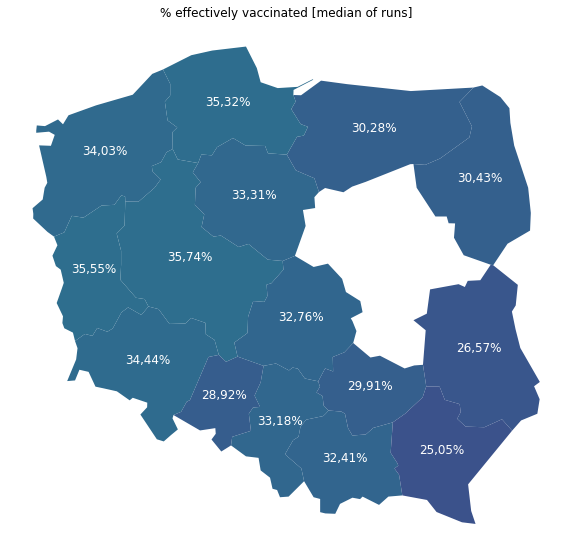

In [42]:
ax = pef_geom.plot('% effectively vaccinated [median of runs]', legend=False, vmin = 0., vmax=100.0, figsize = (10,10))
for _, row in pef_geom.iterrows():
    n = row['% effectively vaccinated [median of runs]']
    ax.text(row.geometry.centroid.x-50000, row.geometry.centroid.y, f'{n}%'.replace('.',','), fontsize = 12, color='w')
    plt.axis('off')
    plt.title('% effectively vaccinated [median of runs]')

### What's the impact of J&J in perc. points?

In [45]:
jansen_first_doses / dens['Denominator']

Region
PL            NaN
PL21     0.068309
PL22     0.070732
PL41     0.061085
PL42     0.080955
PL43     0.094010
PL51     0.076291
PL52     0.057941
PL61     0.075927
PL62     0.066056
PL63     0.074273
PL71     0.064683
PL72     0.066815
PL81     0.060132
PL82     0.056127
PL84     0.062647
PL92X         NaN
dtype: float64